In [317]:
import torch 
import torch.nn as nn
import torch.nn.init as init
from copy import deepcopy
# global seed
seed = 42
torch.manual_seed(seed)

import matplotlib.pyplot as plt

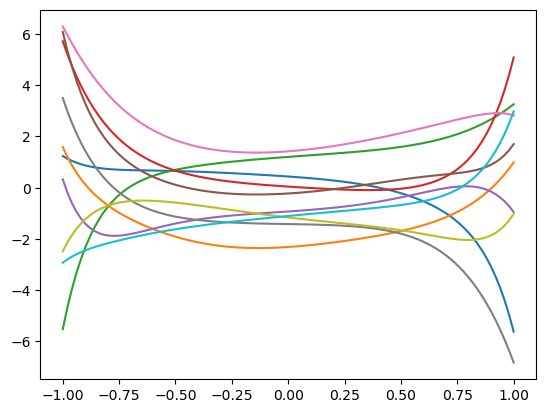

In [338]:
rand_coefs1 = torch.randn(10)
def f1(x):
    res = 0
    for i in range(len(rand_coefs)):
        res += rand_coefs[i] * (x ** i)
    return res

def f2(x):
    res = 0
    for i in range(4):
        res += rand_coefs1[i] * (x ** i)
    return res

def objective_generator(num_funcs):
    funcs = []
    for i in range(num_funcs):
        def f(x):
            rand_coefs = torch.randn(11)       
            res = 0
            for i in range(len(rand_coefs)):
                res += rand_coefs[i] * (x ** i)
            return res
        funcs.append(f)
    return funcs

test_range = torch.linspace(-1, 1, 100)
funcs = objective_generator(10)
for f in funcs:
    plt.plot(test_range, f(test_range), label='f')


In [350]:
def create_nets(num: int=5):
    net = nn.Sequential(
        nn.Linear(1, 15),
        nn.ReLU(),
        nn.Linear(15, 1)
    )

    xavier_init_sequential(net)

    nets = [deepcopy(net) for _ in range(num)]
    num_params = sum(p.numel() for p in nets[0].parameters())

    # meta_optimizer = nn.Sequential(
    #     nn.Linear(num_params*2, num_params*20),
    #     nn.ReLU(),
    #     nn.Linear(num_params*20, num_params),
    #     nn.ReLU(),
    #     nn.Linear(num_params, num_params)
    # )
    # xavier_init_sequential(meta_optimizer)
    return nets


In [351]:
def xavier_init_sequential(model):
    """
    Apply Xavier initialization to the weights of all applicable layers
    in a torch.nn.Sequential model.

    Args:
        model (torch.nn.Sequential): The model to initialize.
    """
    for layer in model:
        if isinstance(layer, nn.Linear):  # Check if the layer has weights to initialize
            init.xavier_uniform_(layer.weight)  # Apply Xavier uniform initialization
            if layer.bias is not None:  # Initialize bias to zero
                init.zeros_(layer.bias)

In [356]:
# random floats between -1, 1
X = torch.rand(10000, 1) * 2 - 1

num_tasks = 1
funcs = objective_generator(num_tasks)
labels = [f(X) for f in funcs]
# rescale each labels to -1, 1
labels = [(l - l.min()) / (l.max() - l.min()) * 2 - 1 for l in labels]
labels = torch.stack(labels, dim=1)
print(labels[:3,:2])
X.shape, labels.shape

tensor([[[-0.9017]],

        [[-0.9149]],

        [[-0.9018]]])


(torch.Size([10000, 1]), torch.Size([10000, 1, 1]))

In [357]:
losses= {i: [] for i in range(num_tasks)}
batch_size = 32

nets = create_nets(num_tasks)
for net_id, net in enumerate(nets):
    for epoch in range(500):
        for batch_idx in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            y = labels[:, net_id]
            y_batch = y[i:i+batch_size]
            net.train()
            y_pred = net(X_batch)
                    
            loss = ((y_pred - y_batch)**2).sum()
            losses[net_id].append(loss.item())
            loss.backward()

            # params = torch.cat([p.detach().view(-1) for p in net.parameters()])
            # grads = torch.cat([p.grad.detach().view(-1) for p in net.parameters()])
            # grads[torch.isnan(grads)] = 0

            # # concat params and grads
            # params_grads = torch.cat([params, grads])


            with torch.no_grad():
                for p in net.parameters():
                    p -= 1e-3 * p.grad
                    p.grad.zero_()
            # updated_params = torch.cat([p.view(-1).detach() for p in net.parameters()])
            # net.eval()
            # predicted_params = meta_optimizer(params_grads)



            # meta_loss = ((updated_params - predicted_params)**2).sum()
            # meta_loss.backward()
            # with torch.no_grad():
            #     for p in net.parameters():
            #         p -= 1e-3 * p.grad
            #         p.grad.zero_()
            # meta_loss = torch.tensor(0) 

            if batch_idx%500 ==0:
                print(f"Net {net_id}, Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}, Meta Loss {meta_loss.item()}")
            


Net 0, Epoch 0, Batch 0, Loss 16.60868263244629, Meta Loss 9.331060409545898
Net 0, Epoch 0, Batch 4000, Loss 1.2785476446151733, Meta Loss 9.331060409545898
Net 0, Epoch 0, Batch 8000, Loss 0.9156034588813782, Meta Loss 9.331060409545898
Net 0, Epoch 1, Batch 0, Loss 0.8488458395004272, Meta Loss 9.331060409545898
Net 0, Epoch 1, Batch 4000, Loss 0.7390794157981873, Meta Loss 9.331060409545898
Net 0, Epoch 1, Batch 8000, Loss 0.648425817489624, Meta Loss 9.331060409545898
Net 0, Epoch 2, Batch 0, Loss 0.6065807342529297, Meta Loss 9.331060409545898
Net 0, Epoch 2, Batch 4000, Loss 0.53392094373703, Meta Loss 9.331060409545898
Net 0, Epoch 2, Batch 8000, Loss 0.47216111421585083, Meta Loss 9.331060409545898
Net 0, Epoch 3, Batch 0, Loss 0.4441329836845398, Meta Loss 9.331060409545898
Net 0, Epoch 3, Batch 4000, Loss 0.39346739649772644, Meta Loss 9.331060409545898
Net 0, Epoch 3, Batch 8000, Loss 0.3486403226852417, Meta Loss 9.331060409545898
Net 0, Epoch 4, Batch 0, Loss 0.3286128938

KeyboardInterrupt: 

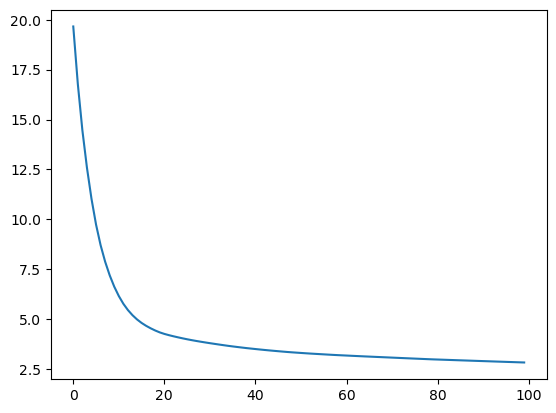

In [354]:
# plot losses
cutoff = 100
for i in range(num_tasks):
    plt.plot(losses[i][:cutoff], label=f'Net {i}')
plt.show()

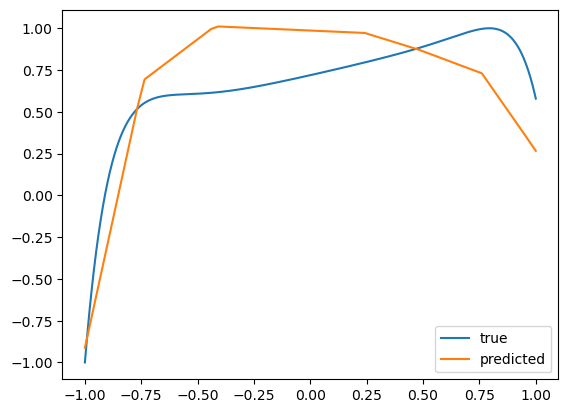

In [355]:
for i,net in enumerate(nets[:10]):
    net.eval()
    X_test = torch.linspace(-1, 1, 1000).reshape(-1, 1)
    y_test = funcs[i](X_test)
    y_test = (y_test - y_test.min()) / (y_test.max() - y_test.min()) * 2 - 1
    y_pred = net(X_test)

    plt.plot(X_test, y_test, label='true')
    plt.plot(X_test, y_pred.detach(), label='predicted')
    plt.legend()
    plt.show()